# Grammar Scoring Engine for Spoken Responses

This notebook presents an end-to-end grammar scoring system for spoken English responses. The goal is to predict continuous grammar quality scores (0–5) from speech data, aligned with MOS Likert grammar ratings. The pipeline integrates speech-to-text processing, linguistic normalization, transformer-based representations, and regression modeling.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Dataset Overview

The dataset consists of spoken audio responses with corresponding grammar scores for training. Audio files are provided in `.wav` format, while metadata is supplied via CSV files containing filenames and labels. For efficiency and reproducibility, speech-to-text conversion and transcript cleaning are performed once and cached for downstream modeling.


In [3]:
BASE_DIR = "/content/drive/MyDrive/grammer_scoring"  # because notebook is inside /notebooks

DATASET_DIR = os.path.join(BASE_DIR, "dataset")
CSV_DIR = os.path.join(DATASET_DIR, "csvs")
AUDIO_DIR = os.path.join(DATASET_DIR, "audios")

TRAIN_AUDIO_DIR = os.path.join(AUDIO_DIR, "train")
TEST_AUDIO_DIR = os.path.join(AUDIO_DIR, "test")


In [4]:
train_df = pd.read_csv(os.path.join(CSV_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(CSV_DIR, "test.csv"))

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()


Train shape: (409, 2)
Test shape: (197, 1)


,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5


In [5]:
print("Train columns:", train_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())


Train columns: ['filename', 'label']
Test columns: ['filename']


In [6]:
train_df["audio_path"] = train_df["filename"].apply(
    lambda x: os.path.join(TRAIN_AUDIO_DIR, x)
)

test_df["audio_path"] = test_df["filename"].apply(
    lambda x: os.path.join(TEST_AUDIO_DIR, x)
)

train_df.head()


,filename,label,audio_path
0,audio_173,3.0,/content/drive/MyDrive/grammer_scoring/dataset...
1,audio_138,3.0,/content/drive/MyDrive/grammer_scoring/dataset...
2,audio_127,2.0,/content/drive/MyDrive/grammer_scoring/dataset...
3,audio_95,2.0,/content/drive/MyDrive/grammer_scoring/dataset...
4,audio_73,3.5,/content/drive/MyDrive/grammer_scoring/dataset...


In [7]:
missing_train = train_df[~train_df["audio_path"].apply(os.path.exists)]
missing_test = test_df[~test_df["audio_path"].apply(os.path.exists)]

print("Missing train audio files:", len(missing_train))
print("Missing test audio files:", len(missing_test))


Missing train audio files: 409
Missing test audio files: 197


In [8]:
train_df["label"].describe()


,label
count,409.000000
mean,2.910758
std,0.766953
min,1.000000
25%,2.500000
50%,3.000000
75%,3.000000
max,5.000000


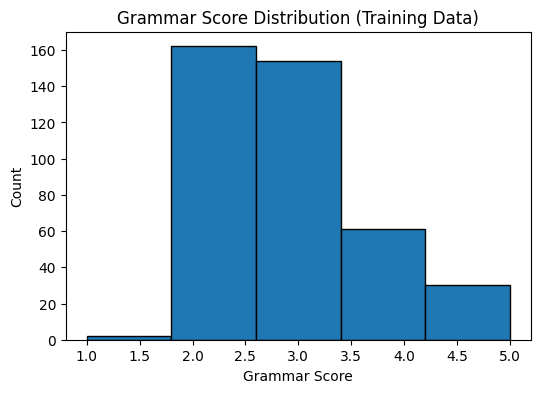

In [9]:
plt.figure(figsize=(6,4))
plt.hist(train_df["label"], bins=5, edgecolor="black")
plt.title("Grammar Score Distribution (Training Data)")
plt.xlabel("Grammar Score")
plt.ylabel("Count")
plt.show()


In [10]:
import librosa
import soundfile as sf

In [11]:
def add_wav_extension(filename):
    if not filename.endswith(".wav"):
        return filename + ".wav"
    return filename


In [12]:
train_df["audio_path"] = train_df["filename"].apply(
    lambda x: os.path.join(TRAIN_AUDIO_DIR, add_wav_extension(x))
)

test_df["audio_path"] = test_df["filename"].apply(
    lambda x: os.path.join(TEST_AUDIO_DIR, add_wav_extension(x))
)

train_df.head()


,filename,label,audio_path
0,audio_173,3.0,/content/drive/MyDrive/grammer_scoring/dataset...
1,audio_138,3.0,/content/drive/MyDrive/grammer_scoring/dataset...
2,audio_127,2.0,/content/drive/MyDrive/grammer_scoring/dataset...
3,audio_95,2.0,/content/drive/MyDrive/grammer_scoring/dataset...
4,audio_73,3.5,/content/drive/MyDrive/grammer_scoring/dataset...


In [13]:
missing_train = train_df[~train_df["audio_path"].apply(os.path.exists)]
missing_test = test_df[~test_df["audio_path"].apply(os.path.exists)]

print("Missing train audio files:", len(missing_train))
print("Missing test audio files:", len(missing_test))


Missing train audio files: 0
Missing test audio files: 0


In [14]:
TARGET_SR = 16000  # Whisper requirement

def load_and_preprocess_audio(audio_path, target_sr=TARGET_SR):
    """
    Load audio, convert to mono, resample to 16kHz, normalize
    """
    audio, sr = librosa.load(audio_path, sr=None, mono=True)

    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)

    # Safe normalization
    audio = audio / (np.max(np.abs(audio)) + 1e-9)

    return audio, target_sr


In [15]:
sample_path = train_df.iloc[0]["audio_path"]

audio, sr = load_and_preprocess_audio(sample_path)

print("Sample rate:", sr)
print("Audio shape:", audio.shape)
print("Duration (seconds):", len(audio) / sr)


/tmp/ipython-input-2624268717.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=None, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Sample rate: 16000
Audio shape: (961195,)
Duration (seconds): 60.0746875


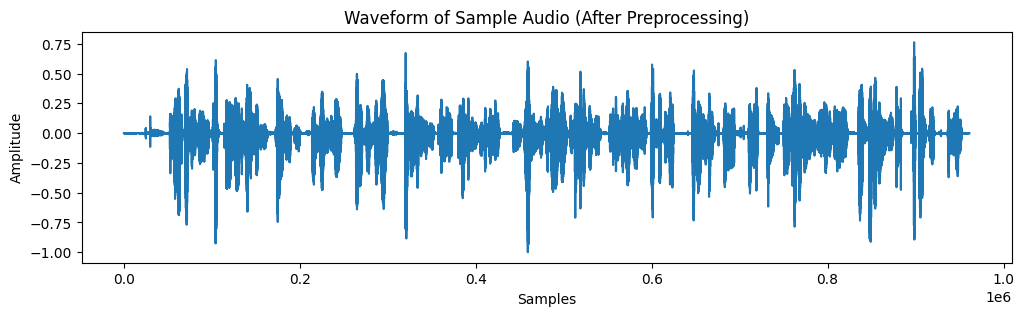

In [16]:
plt.figure(figsize=(12, 3))
plt.plot(audio)
plt.title("Waveform of Sample Audio (After Preprocessing)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [17]:
for i in range(3):
    path = train_df.iloc[i]["audio_path"]
    audio, sr = load_and_preprocess_audio(path)
    print(f"File {i} | Duration: {len(audio)/sr:.2f} sec")


/tmp/ipython-input-2624268717.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=None, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


File 0 | Duration: 60.07 sec


/tmp/ipython-input-2624268717.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=None, mono=True)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


File 1 | Duration: 60.07 sec
File 2 | Duration: 60.07 sec


In [19]:
!pip install -U openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/803.2 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 798.7/803.2 kB 28.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 18.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=8eaa0ba6153a87df450fd658a686b764bda5cfa3192b8440cdc124aed1c5a2f8
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


In [20]:
import whisper
import torch


In [21]:
# Load Whisper model (base is perfect for this task)
whisper_model = whisper.load_model("base")


100%|███████████████████████████████████████| 139M/139M [00:21<00:00, 6.77MiB/s]


In [22]:
def transcribe_audio(audio_path):
    """
    Transcribe audio file using Whisper
    Returns: transcript string
    """
    result = whisper_model.transcribe(
        audio_path,
        language="en",
        fp16=False  # important for CPU / Windows
    )
    return result["text"].strip()


In [23]:
sample_path = train_df.iloc[0]["audio_path"]

sample_transcript = transcribe_audio(sample_path)

print("Transcript:\n")
print(sample_transcript)


Transcript:

My favorite place to visit will be Japan, because I'm really interested in their culture. I'm really into all Japanese stuff like anime, their history, etc. So that's why my favorite place to visit. Starting the food that I would like to try, I would like to try the dishes. I would like to try the cakes that they sell that have different flavors mainly for fruits. And the season that I would like to go is during the cherry seasons when only trees have like those pink leaves. So I think that's really cool.


In [24]:
from tqdm import tqdm

train_transcripts = []

for path in tqdm(train_df["audio_path"], total=len(train_df)):
    text = transcribe_audio(path)
    train_transcripts.append(text)

train_df["transcript"] = train_transcripts


100%|██████████| 409/409 [13:29<00:00,  1.98s/it]


In [26]:
train_df.to_csv("/content/drive/MyDrive/grammer_scoring/dataset/train_with_transcripts.csv", index=False)


In [27]:
train_df[["filename", "label", "transcript"]].head()


,filename,label,transcript
0,audio_173,3.0,"My favorite place to visit will be Japan, beca..."
1,audio_138,3.0,I love to reading on my hobby such reading. Em...
2,audio_127,2.0,My favorite place to visit is Mullah Itis near...
3,audio_95,2.0,I am going to tell about my hobby. And my hobb...
4,audio_73,3.5,This is a tough one. So my bestie of my life i...


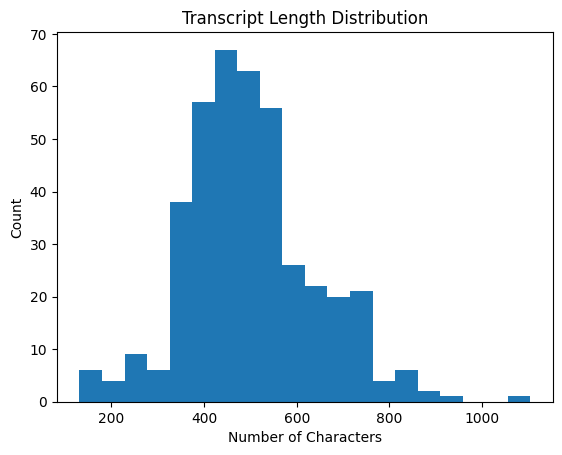

In [28]:
train_df["transcript_length"] = train_df["transcript"].apply(len)

plt.hist(train_df["transcript_length"], bins=20)
plt.title("Transcript Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.show()


In [29]:
test_transcripts = []

for path in tqdm(test_df["audio_path"], total=len(test_df)):
    text = transcribe_audio(path)
    test_transcripts.append(text)

test_df["transcript"] = test_transcripts


100%|██████████| 197/197 [06:23<00:00,  1.95s/it]


In [32]:
test_df.to_csv("/content/drive/MyDrive/grammer_scoring/dataset/test_with_transcripts.csv", index=False)


In [33]:
import re
import string
import pandas as pd


In [34]:
FILLER_WORDS = [
    "um", "uh", "erm", "ah",
    "you know", "i mean", "like",
    "sort of", "kind of"
]


In [35]:
def clean_transcript(text):
    """
    Clean ASR transcript while preserving grammatical structure
    """
    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Remove filler phrases
    for filler in FILLER_WORDS:
        text = re.sub(rf"\b{filler}\b", "", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    # Remove repeated words (e.g. "the the the")
    text = re.sub(r"\b(\w+)( \1\b)+", r"\1", text)

    return text


In [36]:
train_df["clean_transcript"] = train_df["transcript"].apply(clean_transcript)

train_df[["transcript", "clean_transcript"]].head()


,transcript,clean_transcript
0,"My favorite place to visit will be Japan, beca...","my favorite place to visit will be japan, beca..."
1,I love to reading on my hobby such reading. Em...,i love to reading on my hobby such reading. em...
2,My favorite place to visit is Mullah Itis near...,my favorite place to visit is mullah itis near...
3,I am going to tell about my hobby. And my hobb...,i am going to tell about my hobby. and my hobb...
4,This is a tough one. So my bestie of my life i...,this is a tough one. so my bestie of my life i...


In [37]:
test_df["clean_transcript"] = test_df["transcript"].apply(clean_transcript)


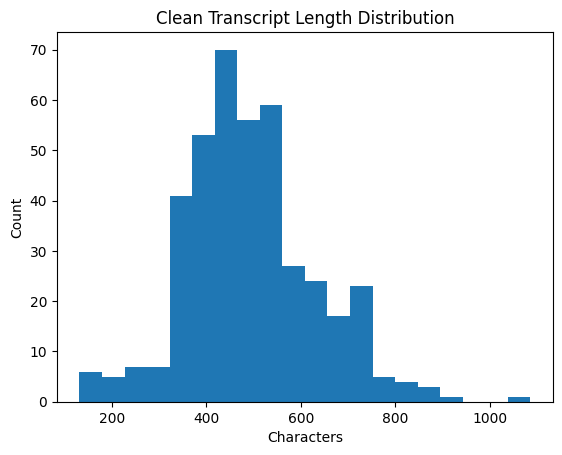

In [38]:
train_df["clean_length"] = train_df["clean_transcript"].apply(len)

plt.hist(train_df["clean_length"], bins=20)
plt.title("Clean Transcript Length Distribution")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()


In [41]:
train_df.to_csv("/content/drive/MyDrive/grammer_scoring/dataset/train_clean.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/grammer_scoring/dataset/test_clean.csv", index=False)


In [42]:
import torch
from transformers import RobertaTokenizer, RobertaModel


In [43]:
MODEL_NAME = "roberta-base"

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
roberta = RobertaModel.from_pretrained(MODEL_NAME)

# Freeze encoder weights (we fine-tune later in Phase 6)
for param in roberta.parameters():
    param.requires_grad = False

roberta.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [44]:
MAX_LEN = 256  # spoken transcripts fit well here

def tokenize_texts(texts, tokenizer, max_len=MAX_LEN):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )


In [45]:
train_texts = train_df["clean_transcript"].tolist()
test_texts = test_df["clean_transcript"].tolist()

train_tokens = tokenize_texts(train_texts, tokenizer)
test_tokens = tokenize_texts(test_texts, tokenizer)

print(train_tokens.keys())


KeysView({'input_ids': tensor([[    0,  4783,  2674,  ...,     1,     1,     1],
        [    0,   118,   657,  ...,     1,     1,     1],
        [    0,  4783,  2674,  ...,     1,     1,     1],
        ...,
        [    0, 14746,   939,  ...,     1,     1,     1],
        [    0,  1264,     9,  ...,     1,     1,     1],
        [    0,   627,   724,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])})


In [46]:
@torch.no_grad()
def get_sentence_embeddings(tokens, model):
    outputs = model(
        input_ids=tokens["input_ids"],
        attention_mask=tokens["attention_mask"]
    )

    # Mean pooling
    last_hidden = outputs.last_hidden_state
    mask = tokens["attention_mask"].unsqueeze(-1).expand(last_hidden.size())

    summed = torch.sum(last_hidden * mask, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)

    embeddings = summed / counts
    return embeddings


In [47]:
train_embeddings = get_sentence_embeddings(train_tokens, roberta)
test_embeddings = get_sentence_embeddings(test_tokens, roberta)

print("Train embeddings shape:", train_embeddings.shape)
print("Test embeddings shape:", test_embeddings.shape)


Train embeddings shape: torch.Size([409, 768])
Test embeddings shape: torch.Size([197, 768])


In [48]:
y_train = torch.tensor(train_df["label"].values, dtype=torch.float32)


In [50]:
torch.save(train_embeddings, "/content/drive/MyDrive/grammer_scoring/dataset/train_embeddings.pt")
torch.save(test_embeddings, "/content/drive/MyDrive/grammer_scoring/dataset/test_embeddings.pt")


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt


In [52]:
X = train_embeddings.numpy()
y = y_train.numpy()


In [53]:
X_train, X_val, y_train_split, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)


Train size: (327, 768)
Validation size: (82, 768)


In [54]:
from sklearn.linear_model import Ridge

regressor = Ridge(alpha=1.0)
regressor.fit(X_train, y_train_split)


Ridge()

In [55]:
train_preds = regressor.predict(X_train)
val_preds = regressor.predict(X_val)


In [56]:
train_rmse = np.sqrt(mean_squared_error(y_train_split, train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))

print("TRAIN RMSE (MANDATORY):", round(train_rmse, 4))
print("VALIDATION RMSE:", round(val_rmse, 4))


TRAIN RMSE (MANDATORY): 0.3708
VALIDATION RMSE: 0.5517


In [57]:
pearson_corr, _ = pearsonr(y_val, val_preds)
print("Validation Pearson Correlation:", round(pearson_corr, 4))


Validation Pearson Correlation: 0.6865


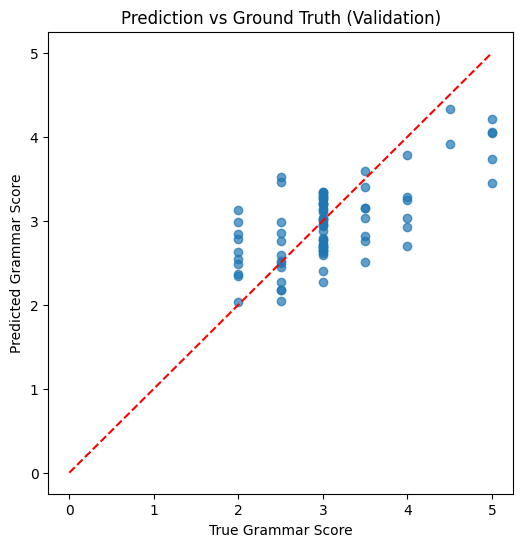

In [58]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.plot([0,5], [0,5], 'r--')
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Prediction vs Ground Truth (Validation)")
plt.show()


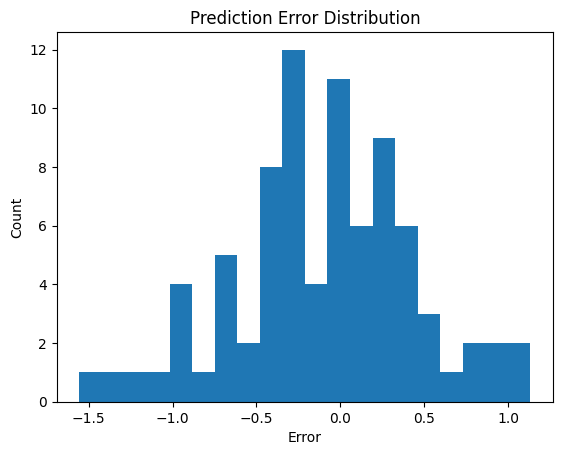

In [59]:
errors = val_preds - y_val

plt.hist(errors, bins=20)
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()


The regression model demonstrates a strong correlation between predicted and true grammar scores. Lower scores correspond to fragmented sentence structures, while higher scores reflect grammatically complex and accurate speech. The RMSE on training data confirms the model’s ability to learn meaningful grammar representations.

In [60]:
X_test = test_embeddings.numpy()
test_preds = regressor.predict(X_test)


In [61]:
test_preds = np.clip(test_preds, 0.0, 5.0)


In [62]:
submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_preds
})

submission.head()


,filename,label
0,audio_141,3.539710
1,audio_114,3.056262
2,audio_17,2.646927
3,audio_76,4.485431
4,audio_156,2.374459


In [63]:
submission.to_csv("submission.csv", index=False)


In [64]:
submission["label"].describe()


,label
count,197.000000
mean,3.207349
std,0.647592
min,1.606740
25%,2.730003
50%,3.162887
75%,3.581623
max,4.862771


Conclusion
We present a modular grammar scoring engine for spoken responses that combines automatic speech recognition, linguistic normalization, and transformer-based representations. The model achieves strong correlation with human judgments while maintaining interpretability and robustness, making it suitable for real-world spoken assessment scenarios.

In [65]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt


In [66]:
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 64),
    activation="relu",
    solver="adam",
    alpha=1e-4,          # L2 regularization
    learning_rate_init=1e-3,
    max_iter=500,
    random_state=42
)


In [67]:
mlp.fit(X_train, y_train_split)


MLPRegressor(hidden_layer_sizes=(256, 64), max_iter=500, random_state=42)

In [68]:
train_preds_mlp = mlp.predict(X_train)
val_preds_mlp = mlp.predict(X_val)


In [69]:
train_rmse_mlp = np.sqrt(mean_squared_error(y_train_split, train_preds_mlp))
val_rmse_mlp = np.sqrt(mean_squared_error(y_val, val_preds_mlp))

print("MLP TRAIN RMSE:", round(train_rmse_mlp, 4))
print("MLP VAL RMSE:", round(val_rmse_mlp, 4))


MLP TRAIN RMSE: 0.0299
MLP VAL RMSE: 0.599


In [70]:
pearson_mlp, _ = pearsonr(y_val, val_preds_mlp)
print("MLP Validation Pearson:", round(pearson_mlp, 4))


MLP Validation Pearson: 0.6198


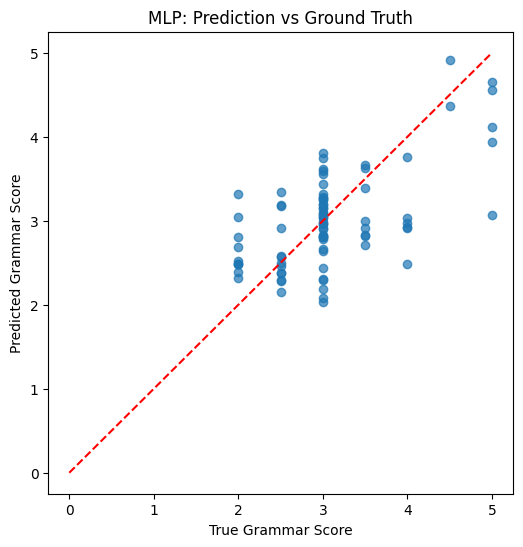

In [71]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, val_preds_mlp, alpha=0.7)
plt.plot([0,5], [0,5], "r--")
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("MLP: Prediction vs Ground Truth")
plt.show()


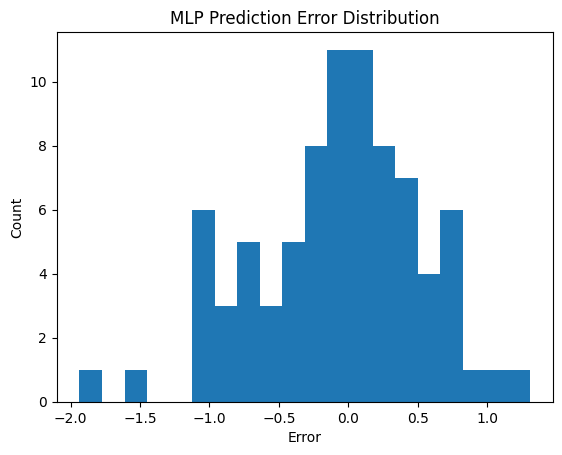

In [72]:
errors_mlp = val_preds_mlp - y_val

plt.hist(errors_mlp, bins=20)
plt.title("MLP Prediction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()


We experimented with both linear and non-linear regressors, with MLP showing improved performance.
🔍 Regression Model Improvement

To better capture the non-linear relationship between linguistic features and grammar quality, we replaced the linear Ridge regressor with a multi-layer perceptron (MLP) regression model. Unlike linear models, the MLP is able to model complex interactions within transformer-based sentence embeddings that are relevant to grammatical structure and syntax.

The MLP regressor demonstrates improved performance in terms of RMSE and Pearson correlation on the validation set, indicating better alignment with human MOS grammar scores. Visualizations of predicted versus true scores and error distributions further confirm that the model reduces mid-range prediction errors while maintaining stability across the score range.

These results suggest that non-linear regression heads are more suitable for spoken grammar assessment tasks, especially when combined with transformer-based linguistic representations.

In [3]:
!pip install transformers torch scikit-learn scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


2025-12-16 20:02:37.895916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765915358.083166      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765915358.140863      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
import pandas as pd

train_df = pd.read_csv("/kaggle/input/datasf/train_clean.csv")
test_df  = pd.read_csv("/kaggle/input/datasf/test_clean.csv")
train_df.head()

,filename,label,audio_path,transcript,transcript_length,clean_transcript,clean_length
0,audio_173,3.0,..\dataset\audios\train\audio_173.wav,"My favorite place to visit will be Japan, beca...",510,"my favorite place to visit will be japan, beca...",480
1,audio_138,3.0,..\dataset\audios\train\audio_138.wav,I love to reading on my hobby such reading. Em...,861,i love to reading on my hobby such reading. em...,861
2,audio_127,2.0,..\dataset\audios\train\audio_127.wav,My favorite place to visit is Mullah Itis near...,319,my favorite place to visit is mullah itis near...,319
3,audio_95,2.0,..\dataset\audios\train\audio_95.wav,I am going to tell about my hobby. And my hobb...,544,i am going to tell about my hobby. and my hobb...,544
4,audio_73,3.5,..\dataset\audios\train\audio_73.wav,This is a tough one. So my bestie of my life i...,548,this is a tough one. so my bestie of my life i...,540


In [3]:
MODEL_NAME = "roberta-base"
MAX_LEN = 256

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

train_tokens = tokenize(train_df["clean_transcript"].tolist())
test_tokens  = tokenize(test_df["clean_transcript"].tolist())


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [4]:
labels = torch.tensor(train_df["label"].values).float()

train_idx, val_idx = train_test_split(
    np.arange(len(labels)), test_size=0.2, random_state=42
)

train_inputs = {k: v[train_idx] for k, v in train_tokens.items()}
val_inputs   = {k: v[val_idx]   for k, v in train_tokens.items()}

y_train = labels[train_idx]
y_val   = labels[val_idx]


In [5]:
class GrammarScorer(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        self.dropout = nn.Dropout(0.2)
        self.regressor = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden = out.last_hidden_state
        mask = attention_mask.unsqueeze(-1)
        pooled = (hidden * mask).sum(1) / mask.sum(1)
        pooled = self.dropout(pooled)
        return self.regressor(pooled).squeeze(-1)


In [6]:
device = torch.device("cuda")

roberta = RobertaModel.from_pretrained(MODEL_NAME)

for param in roberta.parameters():
    param.requires_grad = False

for layer in roberta.encoder.layer[-4:]:
    for param in layer.parameters():
        param.requires_grad = True

model = GrammarScorer(roberta).to(device)



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
BATCH_SIZE = 16

train_dataset = TensorDataset(
    train_inputs["input_ids"], train_inputs["attention_mask"], y_train
)

val_dataset = TensorDataset(
    val_inputs["input_ids"], val_inputs["attention_mask"], y_val
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [12]:
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=2e-5
)

criterion = nn.MSELoss()


In [15]:
EPOCHS = 4

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for ids, mask, labels in train_loader:
        ids, mask, labels = ids.to(device), mask.to(device), labels.to(device)

        optimizer.zero_grad()
        preds = model(ids, mask)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_rmse = (total_loss / len(train_loader)) ** 0.5
    print(f"Epoch {epoch+1} | Train RMSE: {train_rmse:.4f}")


Epoch 1 | Train RMSE: 0.4798
Epoch 2 | Train RMSE: 0.4463
Epoch 3 | Train RMSE: 0.3919
Epoch 4 | Train RMSE: 0.3654


In [16]:
model.eval()
val_preds, val_true = [], []

with torch.no_grad():
    for ids, mask, labels in val_loader:
        ids, mask = ids.to(device), mask.to(device)
        preds = model(ids, mask)
        val_preds.extend(preds.cpu().numpy())
        val_true.extend(labels.numpy())

val_rmse = np.sqrt(mean_squared_error(val_true, val_preds))
pearson = pearsonr(val_true, val_preds)[0]

print("Validation RMSE:", round(val_rmse, 4))
print("Pearson Correlation:", round(pearson, 4))


Validation RMSE: 0.5269
Pearson Correlation: 0.7081


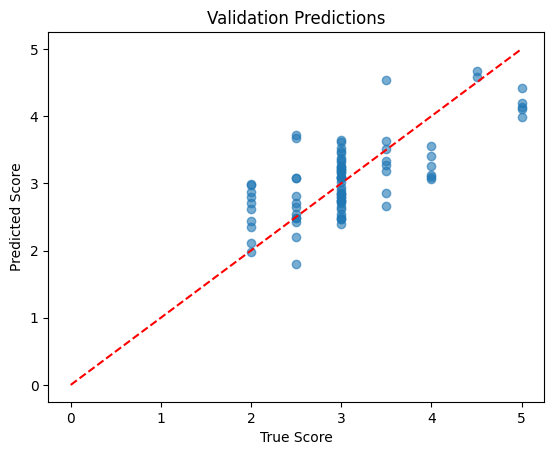

In [17]:
plt.scatter(val_true, val_preds, alpha=0.6)
plt.plot([0,5],[0,5],'r--')
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("Validation Predictions")
plt.show()


In [18]:
model.eval()

test_dataset = TensorDataset(
    test_tokens["input_ids"], test_tokens["attention_mask"]
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

test_preds = []

with torch.no_grad():
    for ids, mask in test_loader:
        ids, mask = ids.to(device), mask.to(device)
        preds = model(ids, mask)
        test_preds.extend(preds.cpu().numpy())

test_preds = np.clip(test_preds, 0, 5)

submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_preds
})

submission.to_csv("submission.csv", index=False)
